In [1]:
import pandas as pd

In [2]:
# use coinpaprika api to get BTC price
import requests
import json
import plotly.graph_objects as go
import plotly.express as px


# Data Ingestion

In [3]:
coins = ['UNI', 'ETH', 'AAVE', 'CAKE', 'CRV', 'SUSHI']
list_of_dfs = []
for coin in coins:
	df = pd.read_json(f"price_data/{coin}USDT.json")
	df['coin'] = coin
	list_of_dfs.append(df)

In [4]:
# create one column for each coin
df = pd.concat(list_of_dfs, axis=0)

In [5]:
df['datetime'] = pd.to_datetime(df['Open time'], unit='ms')

In [6]:
# not safe to use because it aggregates the data, but the index-coin pair is unique so it should be fine
df = pd.pivot_table(df, index='datetime', columns='coin')

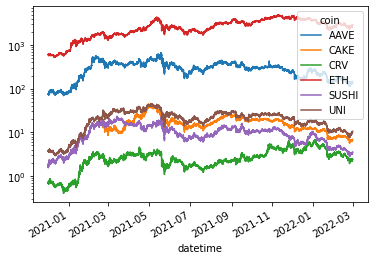

In [7]:
df['Close'].plot(logy=True)
# it worked!

# Analysis

## Creating plot functions and testing them

In [8]:
def get_simple_bar_plot(df, title):
	corr = df.corr()
	corr = corr['UNI'][corr.index != 'UNI']
	corr = corr.sort_values()
	corr = corr.reset_index()
	corr.columns = ['Coin', 'Correlation']
	return px.bar(corr, x='Coin', y='Correlation', color='Correlation', title=title, text_auto=True)

In [9]:
get_simple_bar_plot(df['Close'], 'Correlation of UNI with other coins')

In [10]:
# inspired by https://pastebin.com/gjLus3bS
def get_complete_bar_plot(df, title):
	sorted_corr = df.corr().unstack().sort_values(ascending=False)
	sorted_corr = pd.DataFrame(sorted_corr)
	sorted_corr.index.names = ['Token1', 'Token2']
	sorted_corr = sorted_corr.reset_index()
	sorted_corr.columns = ['TOKEN1', 'TOKEN2', 'Correlation']
	sorted_corr = sorted_corr[sorted_corr['Correlation'] != 1].drop_duplicates(subset='Correlation').reset_index(drop=True)
	sorted_corr['Correlation Pair'] = sorted_corr['TOKEN1']+'-'+sorted_corr['TOKEN2']
	fig = px.bar(sorted_corr, x='Correlation', y='Correlation Pair', color='Correlation',
				color_continuous_scale=px.colors.sequential.Plasma,
				height=800,
				width=1000,
				title=title,
				text_auto=True)
	return fig

In [11]:
get_complete_bar_plot(df['Open'], 'Correlation of all coins')

In [12]:
df['Open']

coin,AAVE,CAKE,CRV,ETH,SUSHI,UNI
datetime,,,,,,
2020-12-01 00:00:00,76.027,NaN,0.675,616.65,1.578,3.7765
2020-12-01 00:15:00,75.456,NaN,0.674,611.92,1.569,3.7484
2020-12-01 00:30:00,76.348,NaN,0.679,613.19,1.576,3.7579
2020-12-01 00:45:00,75.452,NaN,0.676,607.55,1.558,3.7301
2020-12-01 01:00:00,75.073,NaN,0.674,605.57,1.548,3.7307
...,...,...,...,...,...,...
2022-02-28 22:45:00,145.300,6.85,2.426,2918.75,3.477,10.4700
2022-02-28 23:00:00,143.400,6.78,2.400,2897.25,3.441,10.3700
2022-02-28 23:15:00,145.200,6.85,2.446,2911.03,3.478,10.5100


In [13]:
df_open_1d = df['Open'].resample('1D').mean()
px.scatter(x=df_open_1d['UNI'], y=df_open_1d['UNI'])

In [14]:
def get_candle(df, coin, timeframe='1d'):
	close = df.resample(timeframe)['Close'].last()
	open = df.resample(timeframe)['Open'].first()
	volume = df.resample(timeframe)['Volume'].sum()
	high = df.resample(timeframe)['High'].max()
	low = df.resample(timeframe)['Low'].min()
	new_df = pd.concat([open[coin], high[coin], low[coin], close[coin], volume[coin]], axis=1)
	new_df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
	return new_df


In [15]:
from plotly.subplots import make_subplots
def get_candle_plot(df, title):
	fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
               vertical_spacing=0.09, subplot_titles=('OHLC', 'Volume'), 
               row_width=[0.3, 0.7])

	fig.add_trace(go.Candlestick(x=df.index,
								open=df['Open'],
								high=df['High'],
								low=df['Low'],
								close=df['Close'], 
								showlegend=False), 
					row=1, col=1)

	fig.add_trace(go.Bar(x=df.index, y=df['Volume'], showlegend=False),
                  row=2, col=1)

	fig.update_layout(title=title)

	fig.update(layout_xaxis_rangeslider_visible=False)

	return fig
get_candle_plot(get_candle(df, 'ETH', '1d'), 'UNI Candlestick')

## Visualizing price data

In [16]:
# log scale
df_open_1d = df['Open'].resample("1d").mean()
fig = px.line(df_open_1d, title='Prices (log scale)', log_y=True)
fig.write_html('output/01_prices_log.html')
fig.write_image('output/01_prices_log.png')
fig

In [17]:
# multiple lineplots
df_open_1d = df['Open'].resample("1d").mean()
fig = make_subplots(rows=6, cols=1, shared_xaxes=True)
fig.add_scatter(x=df_open_1d.index, y=df_open_1d['UNI'], name='UNI', mode='lines', row=1, col=1)
fig.add_scatter(x=df_open_1d.index, y=df_open_1d['ETH'], name='ETH', mode='lines', row=2, col=1)
fig.add_scatter(x=df_open_1d.index, y=df_open_1d['SUSHI'], name='SUSHI', mode='lines', row=3, col=1)
fig.add_scatter(x=df_open_1d.index, y=df_open_1d['AAVE'], name='AAVE', mode='lines', row=4, col=1)
fig.add_scatter(x=df_open_1d.index, y=df_open_1d['CAKE'], name='CAKE', mode='lines', row=5, col=1)
fig.add_scatter(x=df_open_1d.index, y=df_open_1d['CRV'], name='CRV', mode='lines', row=6, col=1)
# increase the height of the subplots
fig.update_layout(height=800, title='Prices (multiple axis)')
fig.write_html('output/01b_prices_axis.html')
fig.write_image('output/01b_prices_axis.png')
fig

In [18]:
# keep only between 2021-05-01 and 2021-05-31
mask = ((df['Open'].index >= '2021-05-14') & (df['Open'].index <= '2021-07-14')) | ((df['Open'].index >= '2021-12-01') & (df['Open'].index <= '2022-01-31'))
df_open_1d = df['Open'][mask].resample("1d").mean()
# multiple lineplots
fig = make_subplots(rows=6, cols=1, shared_xaxes=True)
fig.add_scatter(x=df_open_1d.index, y=df_open_1d['UNI'], name='UNI', mode='lines', row=1, col=1)
fig.add_scatter(x=df_open_1d.index, y=df_open_1d['ETH'], name='ETH', mode='lines', row=2, col=1)
fig.add_scatter(x=df_open_1d.index, y=df_open_1d['SUSHI'], name='SUSHI', mode='lines', row=3, col=1)
fig.add_scatter(x=df_open_1d.index, y=df_open_1d['AAVE'], name='AAVE', mode='lines', row=4, col=1)
fig.add_scatter(x=df_open_1d.index, y=df_open_1d['CAKE'], name='CAKE', mode='lines', row=5, col=1)
fig.add_scatter(x=df_open_1d.index, y=df_open_1d['CRV'], name='CRV', mode='lines', row=6, col=1)
# increase the height of the subplots
fig.update_layout(height=800, title='Prices (multiple axis)')
fig.write_html('output/02_prices_axis_bear.html')
fig.write_image('output/02_prices_axis_bear.png')
fig

In [19]:
# keep only between 2021-05-01 and 2021-05-31
mask = ((df['Open'].index >= '2022-01-01'))
df_open_1d = df['Open'][mask].resample("1d").mean()
# multiple lineplots
fig = make_subplots(rows=6, cols=1, shared_xaxes=True)
fig.add_scatter(x=df_open_1d.index, y=df_open_1d['UNI'], name='UNI', mode='lines', row=1, col=1)
fig.add_scatter(x=df_open_1d.index, y=df_open_1d['ETH'], name='ETH', mode='lines', row=2, col=1)
fig.add_scatter(x=df_open_1d.index, y=df_open_1d['SUSHI'], name='SUSHI', mode='lines', row=3, col=1)
fig.add_scatter(x=df_open_1d.index, y=df_open_1d['AAVE'], name='AAVE', mode='lines', row=4, col=1)
fig.add_scatter(x=df_open_1d.index, y=df_open_1d['CAKE'], name='CAKE', mode='lines', row=5, col=1)
fig.add_scatter(x=df_open_1d.index, y=df_open_1d['CRV'], name='CRV', mode='lines', row=6, col=1)
# increase the height of the subplots
fig.update_layout(height=800, title='Prices (multiple axis)')
fig.write_html('output/02b_prices_axis_2022.html')
fig.write_image('output/02b_prices_axis_2022.png')
fig

In [20]:
eth_price = df['Open']['ETH'].resample("1d").mean()
eth_volume = df['Volume']['ETH'].resample("1d").sum()
eth_rolling_volume = eth_volume.rolling(window=30, min_periods=0).mean()
df_eth = pd.DataFrame({'price': eth_price, 'volume': eth_volume, 'rolling_volume': eth_rolling_volume})
# plot in two subplots
fig = make_subplots(rows=2, cols=1, shared_xaxes=True)
fig.add_trace(go.Scatter(x=df_eth.index, y=df_eth['price'], name='ETH price'), row=1, col=1)
fig.add_trace(go.Scatter(x=df_eth.index, y=df_eth['volume'], name='ETH volume'), row=2, col=1)
fig.add_trace(go.Scatter(x=df_eth.index, y=df_eth['rolling_volume'], name='ETH rolling volume'), row=2, col=1)
fig.update_layout(height=800, title='ETH price, volume and volume rolling mean for the last 30 days')
fig.write_html('output/02c_eth_price_volume_rolling_volume.html')
fig.write_image('output/02c_eth_price_volume_rolling_volume.png')
fig

## Correlations

In [21]:
fig = get_complete_bar_plot(df['Open'], 'Correlation of all coins')
fig.write_html('output/03_correlation_all_coins.html')
fig.write_image('output/03_correlation_all_coins.png')
fig

In [22]:
fig = get_simple_bar_plot(df['Open'], 'Correlation of UNI with other coins')
fig.write_html('output/04_correlation_uni_coins.html')
fig.write_image('output/04_correlation_uni_coins.png')
fig

In [23]:
mask = ((df['Open'].index >= '2021-05-14') & (df['Open'].index <= '2021-07-14'))
fig = get_complete_bar_plot(df['Open'][mask], 'Correlation of all coins (bear market)')
fig.write_html('output/05a_correlation_all_coins_bear.html')
fig.write_image('output/05a_correlation_all_coins_bear.png')
fig

In [24]:
mask = ((df['Open'].index >= '2021-05-14') & (df['Open'].index <= '2021-07-14'))
fig = get_simple_bar_plot(df['Open'][mask], 'Correlation of UNI with other coins (bear market)')
fig.write_html('output/05_correlation_uni_coins_bear.html')
fig.write_image('output/05_correlation_uni_coins_bear.png')
fig

In [25]:
mask = ((df['Open'].index >= '2022-01-01'))
fig = get_complete_bar_plot(df['Open'][mask], 'Correlation of all coins (2022)')
fig.write_html('output/06a_correlation_all_coins_2022.html')
fig.write_image('output/06a_correlation_all_coins_2022.png')
fig

In [26]:
mask = ((df['Open'].index >= '2022-01-01'))
fig = get_simple_bar_plot(df['Open'][mask], 'Correlation of UNI with other coins (2022)')
fig.write_html('output/06_correlation_uni_coins_2022.html')
fig.write_image('output/06_correlation_uni_coins_2022.png')
fig

In [27]:
eth_price = df['Open']['ETH'].resample("1d").mean()
eth_volume = df['Volume']['ETH'].resample("1d").sum()
eth_rolling_volume = eth_volume.rolling(window=30, min_periods=0).mean()
df_eth = pd.DataFrame({'price': eth_price, 'volume': eth_volume, 'rolling_volume': eth_rolling_volume})

mask = (eth_volume > eth_rolling_volume)

df_open_1d = df['Open'].resample("1d").mean()
df_open_1d = df_open_1d[mask]

fig = get_complete_bar_plot(df_open_1d, 'Correlation of all coins (when ETH volume is above average)')
fig.write_html('output/07a_correlation_all_coins_eth_volume_above_average.html')
fig.write_image('output/07a_correlation_all_coins_eth_volume_above_average.png')
fig

In [28]:
eth_price = df['Open']['ETH'].resample("1d").mean()
eth_volume = df['Volume']['ETH'].resample("1d").sum()
eth_rolling_volume = eth_volume.rolling(window=30, min_periods=0).mean()
df_eth = pd.DataFrame({'price': eth_price, 'volume': eth_volume, 'rolling_volume': eth_rolling_volume})

mask = (eth_volume > eth_rolling_volume)

df_open_1d = df['Open'].resample("1d").mean()
df_open_1d = df_open_1d[mask]

fig = get_simple_bar_plot(df_open_1d, 'Correlation of UNI with other coins (when ETH volume is above average)')
fig.write_html('output/07_correlation_uni_coins_eth_volume_above_average.html')
fig.write_image('output/07_correlation_uni_coins_eth_volume_above_average.png')
fig